# Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. Because these notebooks call from modules used in the live game, I also use them for dev / testing. If something is crashing in the game I can simulate it here to see what is wrong and test out new features before dropping them in the production code. 

In the live game there are three stages of creation:
* The age of **elements** - building terrain
* The age of **mortals** - adding cities and nations
* The age of **conflict** - random events that shift the relationships between nations, towns and people.

Currently only 1 and 2 are shown here. 


In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys, yaml
sys.path.append('../')
sys.path.append('../../')
from lib.builders import world as w, landscape as l
from lib.builders import people,towns,nations,events_dev as events,culture as c

import lib.drawMaps as draw


There are default parameters that I've chosen as the best fit for creating a _ 'believable' _ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 


In [2]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1}

In [3]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

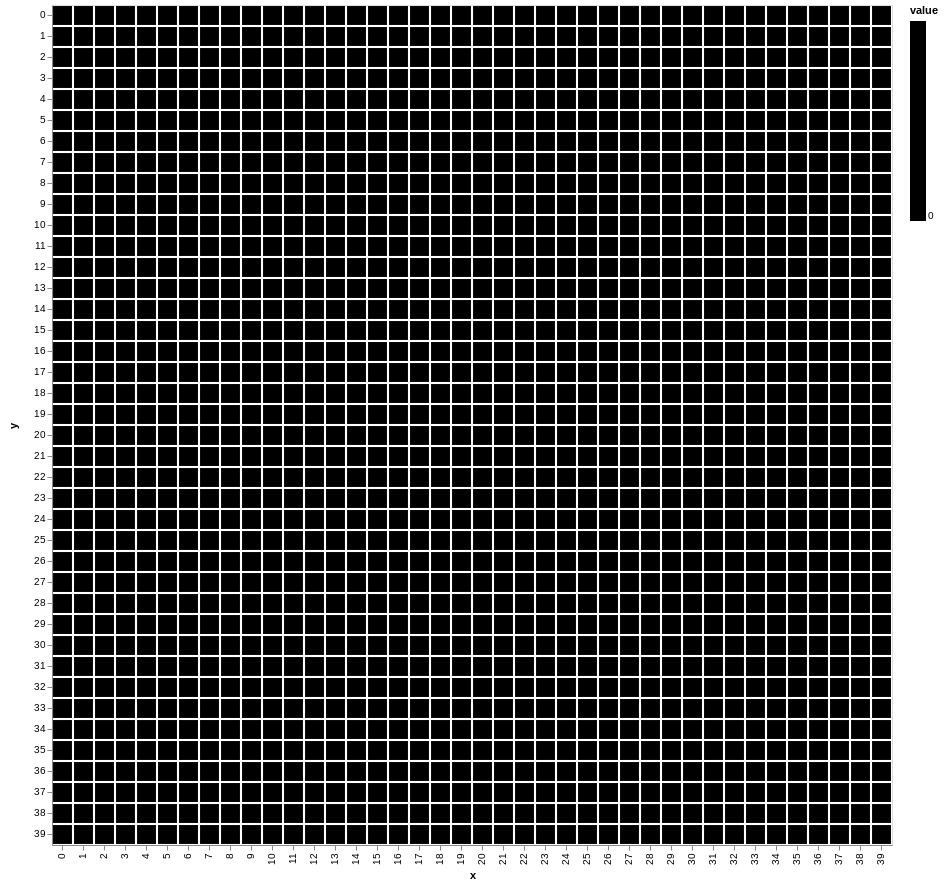

In [4]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated procedurally. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

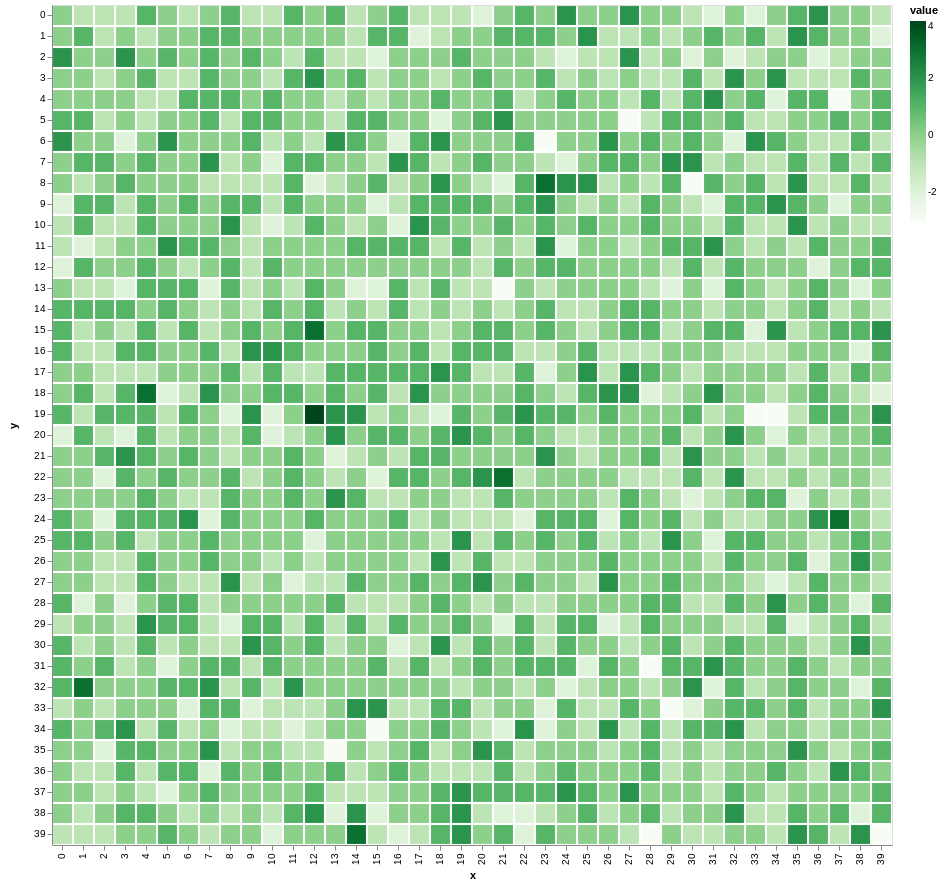

In [5]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [6]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symmetrically.

In [7]:
coord = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", coord)

mdf = world.reindexMountain(coord,m)
mdf

Mountain Placed:  [32 34]


,30,31,32,33,34,35,36,37,38
28,1,1,1,1,1,1,1,1,1
29,1,2,2,2,2,2,2,2,1
30,1,2,3,3,3,3,3,2,1
31,1,2,3,4,4,4,3,2,1
32,1,2,3,4,5,4,3,2,1
33,1,2,3,4,4,4,3,2,1
34,1,2,3,3,3,3,3,2,1
35,1,2,2,2,2,2,2,2,1
36,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

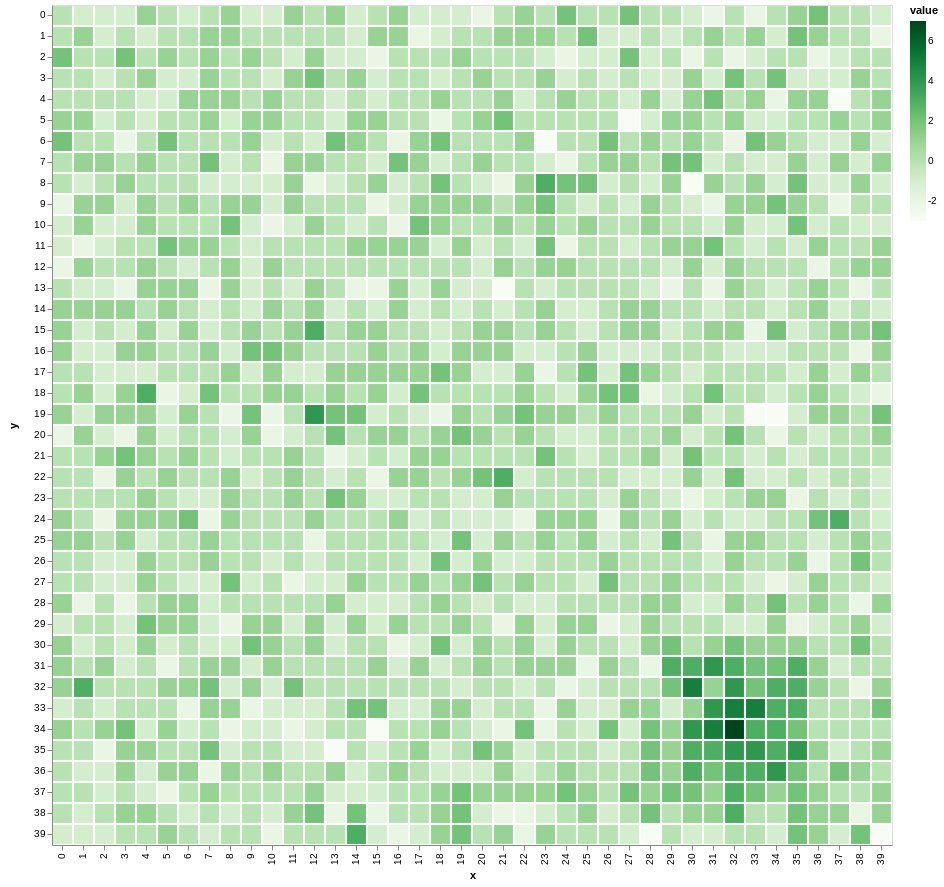

In [8]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board I'll need to create a brownian motion function to drop a mountain and then move. 

In [9]:
world.brownian_land()

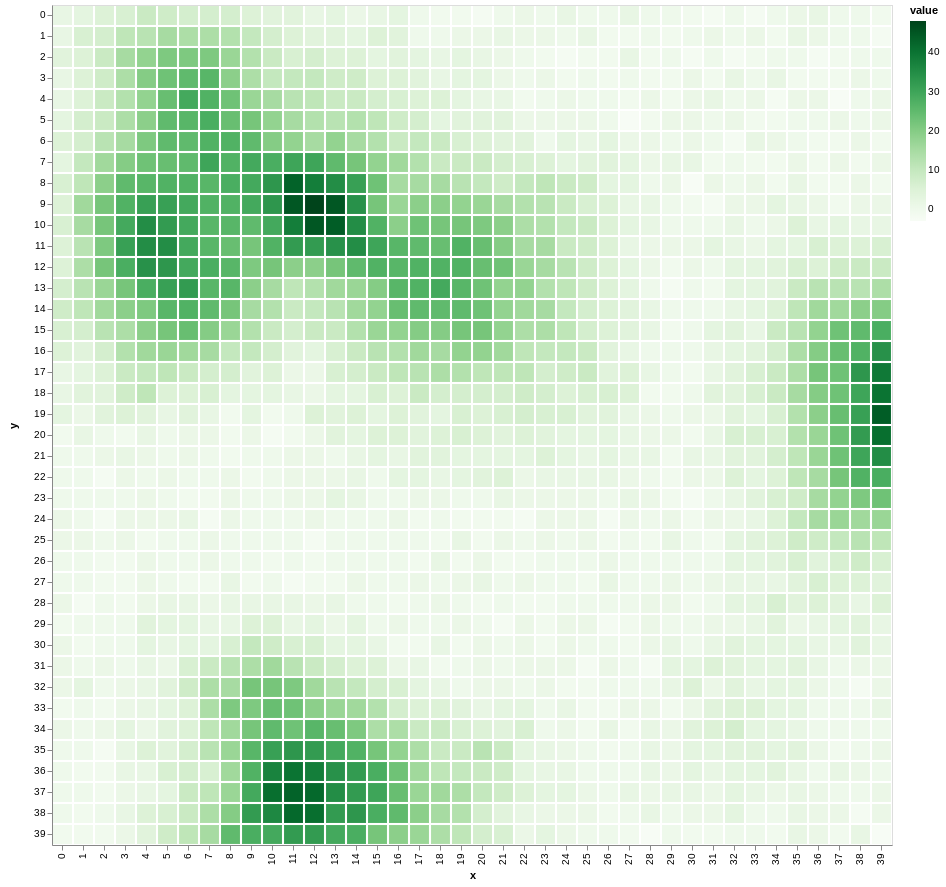

In [10]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `height == 0` then you can assume that lower terrain is _under water_

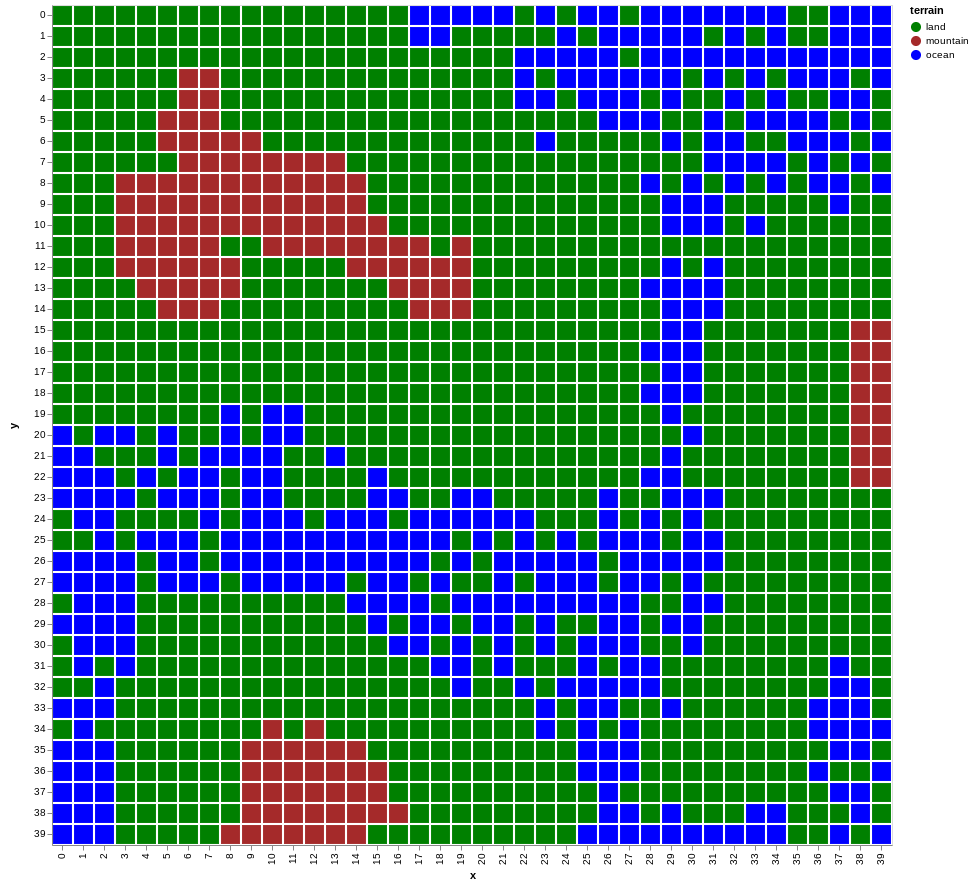

In [11]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rainfall

Rainfall makes terrain different. Wet areas become forests. Dry areas become deserts. 

In [12]:
world.brownian_rainfall()

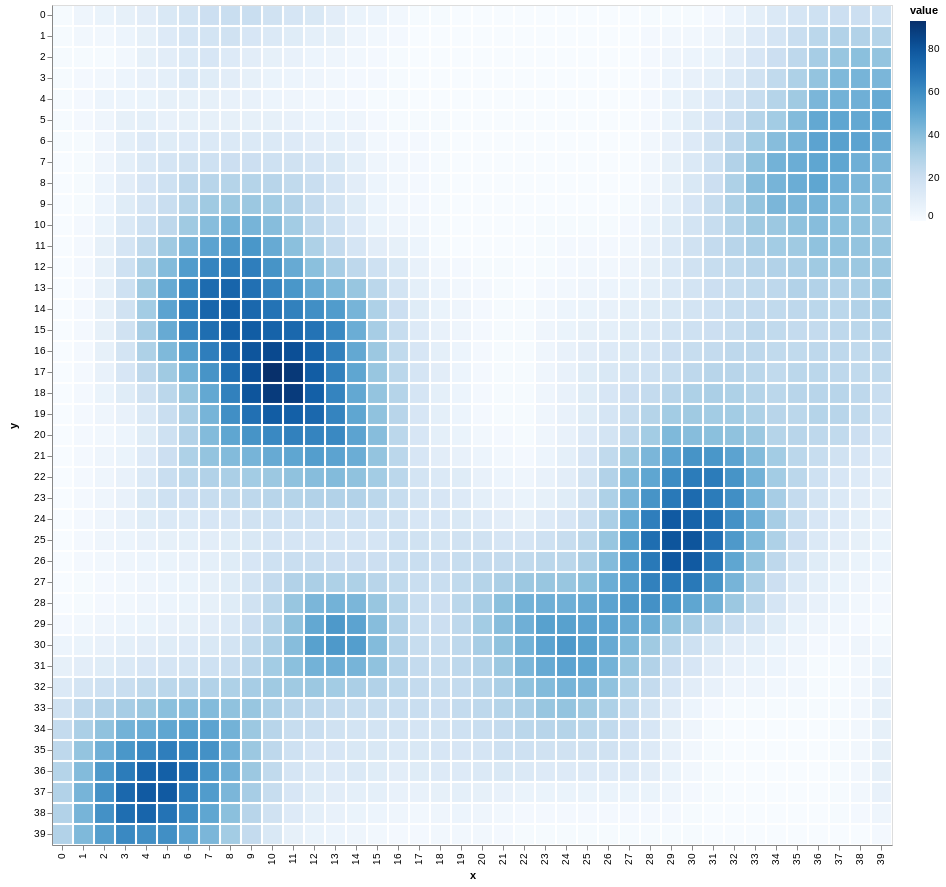

In [13]:
draw.drawRainFall(world.grid_rainfall)

### Build core game features dataframe
This function builds the df_features that will be used later in the actual game. This way you can quickly search and filter the world to find things.

In [14]:
world.build_df_features()

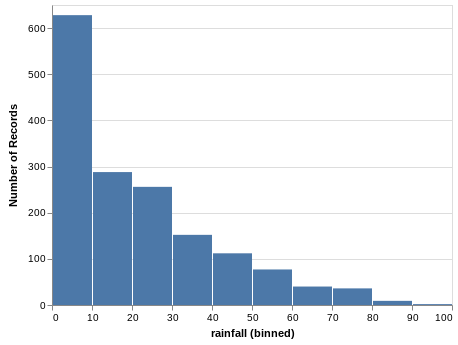

In [15]:
alt.Chart(world.df_features).mark_bar().encode(
    alt.X("rainfall", bin=True),
    y='count()',
)

The amount of rainfal in the world determines if the area will become a forest or a desert. This can be set from the `landscape` parameters. 

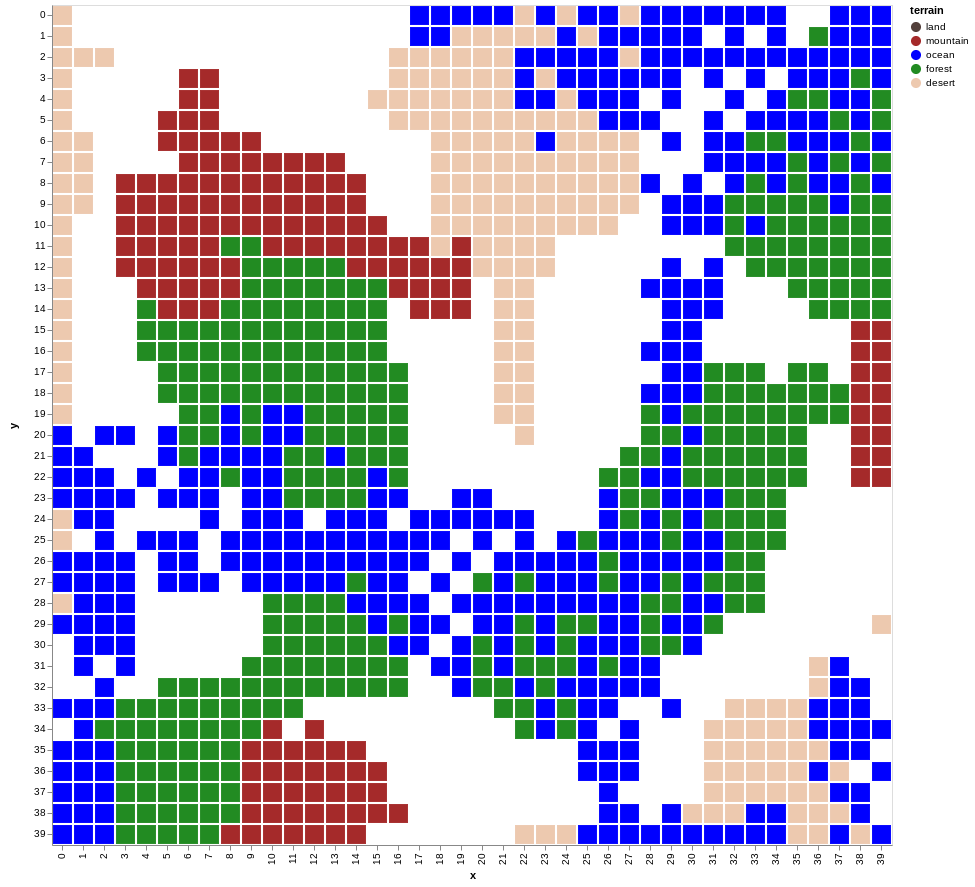

In [16]:
world.df_features['terrain'] = world.df_features.apply(lambda x: w.set_ecology(x,landscape),axis =1 )
draw.drawterrainadvanced(world.df_features)

# The age of the Mortals

The terrain and all of the natural features are formed in the first age. Mountains, rivers, lakes and forests. Once the land has settled, the first cities appear. 

Culture settings come from the user input, there are defaults for everything. Once specified the `.culture` placeholder can be replaced. It should not be used until this point. 


In [17]:
c

<module 'lib.builders.culture' from '../lib/builders/culture.py'>

In [18]:
# the path to the `datasets` folder is different when launched in the Notebook.
culture = c.Culture(paths='notebooks')
world.culture = culture
world.culture.eons

10

## People
A `Person` is a required parameter for many things like `towns`, `nations` and `buildings`

A person requires a `culture` to specify how the names will be generated. As a default the person is a `peon` and exists nowhere (`None`). Optional parameters allow the person to be created with a `role` and a `location`. `Location` can be a `town`, `building` or a `key` where the person can be found. 

In [19]:
people.Person(world.culture,location=world.get_random_chord())

Ekizust the commoner

## Towns

the `__init__` method of a city takes a founding age and a location (which can be generated randomly via `World.get_random_chord`). The init method automatically generates a name. The default nation is the name of the town.

In [20]:
new_town = towns.Town(world.get_random_chord(),1,culture,people)
new_town

town of Camrail: population: 1 location: [35,2] founded 1

In [21]:
new_town.speaker

Johorkef the Speaker of Camrail

## The age of civilization

Cities grow for a set number of aeons. During each eon
* n new villages are born
* each village has g% chance to grow

The cities are randomly placed (not in the ocean)

In [22]:
all_towns = towns.build_towns(world,people)
world.towns = all_towns
[(str(p),p.population) for p in all_towns]

[('town of Heartfellow: population: 3 location: [18,8] founded 0',
  [Ereyellion the Speaker of Heartfellow,
   Quatallut the commoner,
   Kracklart the commoner]),
 ('town of Lionmelt: population: 4 location: [36,29] founded 0',
  [Rastir the Speaker of Lionmelt,
   Xichesh the commoner,
   Dohorkesh the commoner,
   Sarrot the commoner]),
 ('town of Servantslair: population: 5 location: [1,13] founded 0',
  [Fostive the Speaker of Servantslair,
   Kragrot the commoner,
   Paspion the commoner,
   Sosassol the commoner,
   Alogennane the commoner]),
 ('town of Spincrest: population: 3 location: [35,14] founded 1',
  [Pasalkive the Speaker of Spincrest,
   Traggab the commoner,
   Tokrackich the commoner]),
 ('town of Clearwish: population: 5 location: [33,17] founded 1',
  [Olladdomir the Speaker of Clearwish,
   Sogenneb the commoner,
   Ekopeltech the commoner,
   Forushoch the commoner,
   Trirpadle the commoner]),
 ('town of Ragefellow: population: 8 location: [6,6] founded 1',
  

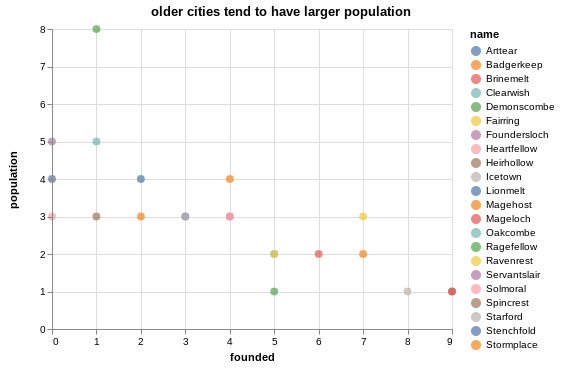

In [23]:
def population_age(towns):
    df = pd.DataFrame(index=range(len(all_towns)))
    df['name'] = [t.name for t in all_towns]
    df['population'] = [t.pop for t in all_towns]
    df['founded'] = [t.founded for t in all_towns]
    return df

alt.Chart(population_age(towns),title="older cities tend to have larger population").mark_circle(size=60).encode(
    y='population',
    x='founded',
    color='name',
    tooltip=['name']
)

## Adding the towns to the map: 

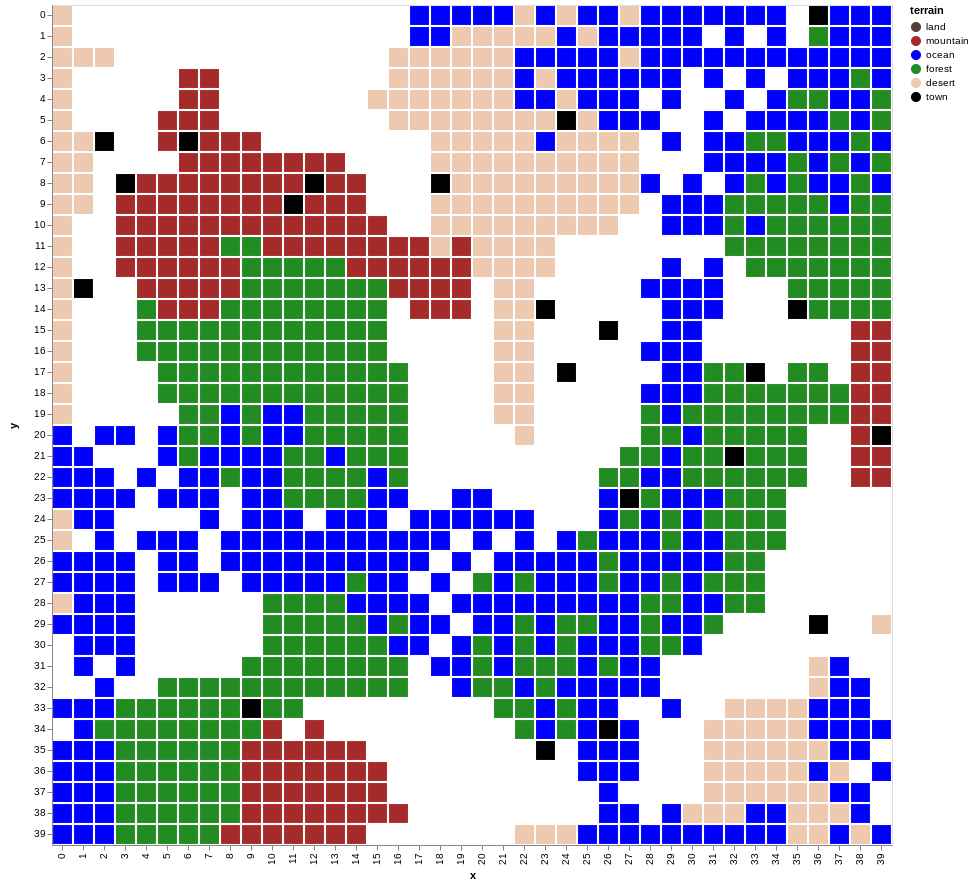

In [24]:
world.add_features(all_towns)
#TODO: Update drawCities to support more terrain types
draw.drawCities(world.df_features)

In [25]:
world.df_features[world.df_features['feature'].isna()==False]

,y,rainfall,x,key,elevation,terrain,feature
key,,,,,,,
36:0,0,19.0,36,36:0,2.0,town,Brinemelt
24:5,5,0.0,24,24:5,1.0,town,Oakcombe
2:6,6,4.0,2,2:6,12.0,town,Solmoral
6:6,6,12.0,6,6:6,25.0,town,Ragefellow
3:8,8,10.0,3,3:8,25.0,town,Mageloch
12:8,8,21.0,12,12:8,38.0,town,Stenchfold
18:8,8,1.0,18,18:8,15.0,town,Heartfellow
11:9,9,29.0,11,11:9,45.0,town,Heirhollow
1:13,13,2.0,1,1:13,12.0,town,Demonscombe


# Nations

In [26]:
#k is the actual k_means cluster object.
all_nations,k = nations.cluster_nations(world)
world.nations = all_nations

all_nations

{0: 'Ragespike',
 1: 'Lionfort',
 2: 'Soilrise',
 3: 'Hellvale',
 4: 'Founderscatch',
 5: 'Ravencrest',
 6: 'Artborourgh',
 7: 'Hardblade'}

Standard Scikit-Learn stuff

In [27]:
k

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
world.df_features = nations.predict_nations(k,world)
world.df_features.head(20)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
0:0,0,1.0,0,0:0,2.0,desert,NaN,1.0,Lionfort
1:0,0,4.0,1,1:0,3.0,plain,NaN,1.0,Lionfort
2:0,0,6.0,2,2:0,5.0,plain,NaN,1.0,Lionfort
3:0,0,8.0,3,3:0,6.0,plain,NaN,1.0,Lionfort
4:0,0,10.0,4,4:0,9.0,plain,NaN,1.0,Lionfort
5:0,0,14.0,5,5:0,8.0,plain,NaN,1.0,Lionfort
6:0,0,17.0,6,6:0,7.0,plain,NaN,1.0,Lionfort
7:0,0,20.0,7,7:0,7.0,plain,NaN,1.0,Lionfort
8:0,0,21.0,8,8:0,7.0,plain,NaN,1.0,Lionfort


The age of conflict is next, so the starting fealty and diplomacy for each town is 1

In [29]:
for t in all_towns:
    try:
        t.set_starting_fielty(world)
    except:
        continue
        
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Lionmelt is loyal to the nation of Soilrise
{'nation': 'Soilrise', 'national fealty': 1}


In [30]:
#for each nation (n), appoint the most populus city (c) as it's capitol.
for n in np.unique(world.df_features['nation'].dropna()):
    cu = world.df_features[(world.df_features['nation']==n)& \
          (world.df_features['terrain']=='town')]['feature'].tolist()
    #getting the town objects
    ts = [t for t in all_towns if t.name in cu]
    #get population(p)
    p = [t.pop for t in ts]
    #getting the first town that has the max population, make that the capitol
    ts[np.argmax(p)].type='capitol'
    
world.towns

[capitol of Heartfellow: population: 3 location: [18,8] founded 0,
 capitol of Lionmelt: population: 4 location: [36,29] founded 0,
 town of Servantslair: population: 5 location: [1,13] founded 0,
 town of Spincrest: population: 3 location: [35,14] founded 1,
 capitol of Clearwish: population: 5 location: [33,17] founded 1,
 capitol of Ragefellow: population: 8 location: [6,6] founded 1,
 town of Badgerkeep: population: 3 location: [23,35] founded 2,
 capitol of Arttear: population: 4 location: [9,33] founded 2,
 town of Stenchfold: population: 3 location: [12,8] founded 3,
 town of Icetown: population: 3 location: [39,20] founded 3,
 town of Foundersloch: population: 3 location: [32,21] founded 4,
 town of Solmoral: population: 3 location: [2,6] founded 4,
 capitol of Magehost: population: 4 location: [26,34] founded 4,
 town of Oakcombe: population: 2 location: [24,5] founded 5,
 town of Fairring: population: 2 location: [23,14] founded 5,
 town of Demonscombe: population: 1 location

In [31]:
world.nations = [nations.Nation(n,world,world.culture,people) for n in world.nations.values()]
world.nations

[Nation of Ragespike,
 Nation of Lionfort,
 Nation of Soilrise,
 Nation of Hellvale,
 Nation of Founderscatch,
 Nation of Ravencrest,
 Nation of Artborourgh,
 Nation of Hardblade]

In [32]:
world.nations[0].towns

[town of Fairring: population: 2 location: [23,14] founded 5,
 capitol of Ravenrest: population: 3 location: [24,17] founded 7,
 town of Stormplace: population: 2 location: [26,15] founded 7,
 town of Starford: population: 1 location: [27,23] founded 8]

In [33]:
world.nations[0].get_capitol().population

[Setoldir the Speaker of Ravenrest,
 Akistow the commoner,
 Thegennam the commoner,
 Tocklane the Ruler of the nation of Ragespike]

So the world has nations, nations have towns, and towns have people. Objects all nested together and easy to reference. A nation's capitol will always have two people: the ruler and the speaker. Larger cities will have extra peons. 

In [34]:
world.nations[0].get_capitol().population[0].get_person_data()

{'name': 'Setoldir',
 'role': 'Speaker of Ravenrest',
 'loyalty': 0.5,
 'temperment': 0.75,
 'attributes': ['alive']}

In [35]:
world.df_features[world.df_features['feature'].isna()==False].sort_values(['nation'])

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
24:5,5,0.0,24,24:5,1.0,town,Oakcombe,6.0,Artborourgh
18:8,8,1.0,18,18:8,15.0,town,Heartfellow,6.0,Artborourgh
35:14,14,25.0,35,35:14,11.0,town,Spincrest,4.0,Founderscatch
32:21,21,51.0,32,32:21,4.0,town,Foundersloch,4.0,Founderscatch
39:20,20,16.0,39,39:20,41.0,town,Icetown,4.0,Founderscatch
33:17,17,26.0,33,33:17,6.0,town,Clearwish,4.0,Founderscatch
36:0,0,19.0,36,36:0,2.0,town,Brinemelt,7.0,Hardblade
9:33,33,36.0,9,9:33,21.0,town,Arttear,3.0,Hellvale
11:9,9,29.0,11,11:9,45.0,town,Heirhollow,1.0,Lionfort


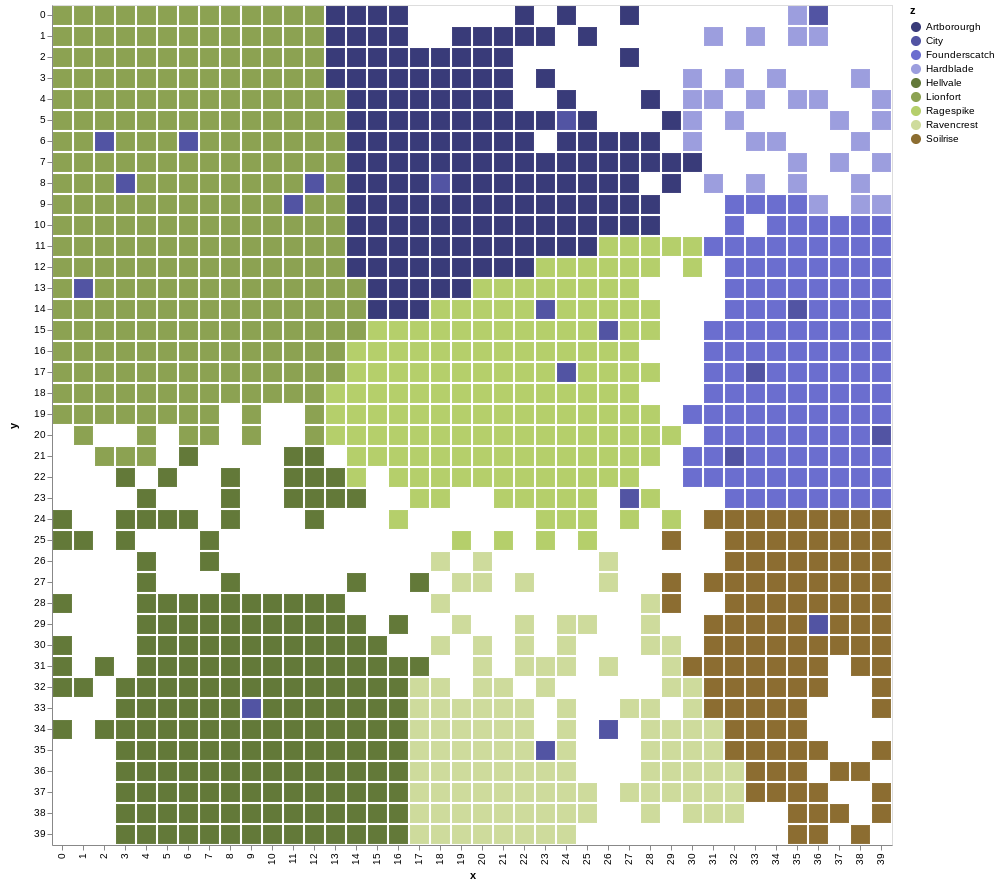

In [36]:
draw.drawboarders(world.df_features)

# The age of the Conflict

The terrain and all of the natural features are formed in the first age. Cities and nations in the second. In the third age chaos will shift the natural order and cause the tension that creates the objectives of the game. 


In [37]:
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Lionmelt is loyal to the nation of Soilrise
{'nation': 'Soilrise', 'national fealty': 1}


People have loyalty to thier nations, as well as towns. Nations have a loyalty to each other. Towns have speakers, who represent the town. Nations have rulers. 

In [38]:
example_nation = world.nations[1]
print (example_nation.ruler," has a temperment of ",example_nation.ruler.temperment)
print (example_nation.get_capitol().speaker," has a loyalty of ",example_nation.get_capitol().speaker.loyalty)

Staggort the Ruler of the nation of Lionfort  has a temperment of  0.14
Vafarrumber the Speaker of Ragefellow  has a loyalty of  0.5


In [39]:
example_nation.towns

[capitol of Ragefellow: population: 8 location: [6,6] founded 1,
 town of Stenchfold: population: 3 location: [12,8] founded 3,
 town of Solmoral: population: 3 location: [2,6] founded 4,
 town of Demonscombe: population: 1 location: [1,13] founded 5,
 town of Mageloch: population: 2 location: [3,8] founded 6,
 town of Heirhollow: population: 1 location: [11,9] founded 9]

## Swaying favor with other nations

Events cause the relationship to sway between nations. This can be done by passing the `nation` or list of `nation` objects into the `alter_favor` function. 

In [40]:
nations.treaties

,stance,favor
0,sworn enemies,0.0
1,war,0.1
2,tense,0.3
3,peace,0.6
4,allies,0.9


In [41]:
help(nations.alter_favor)

Help on function alter_favor in module lib.builders.nations:

alter_favor(s, o, a)
    s = the target nation(s) (obj or list). s will not change. O's favor of s will change.
    o = the nation(s) (obj or list) who's favor is change. O's favor of s will change
    
    Examples:
    (a,[o]) each nation in o's favor of a is changed by s
    (a,o) o's favor of a is changed by s
    ([a],o) o's favor of each nation in a is changed by s
    s = amount of change (int)
    
    national relationship with itself doesn't decay, but town and person loyalty can.



### example 1: one nation does something that many other nations's don't like. 

In [42]:
s_nation = world.nations[0]
o_nations = world.nations[1:3]
affect = -.25
nations.alter_favor(s_nation,o_nations,affect)

In [43]:
print("subject nations (nations who have done the deed)")
print(f"{s_nation} did something {affect} to {o_nations}")
print(s_nation,"\n",yaml.dump(s_nation.diplomacy))

print("object nations (nations who's favor is affected by the deed)")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in o_nations]


subject nations (nations who have done the deed)
Nation of Ragespike did something -0.25 to [Nation of Lionfort, Nation of Soilrise]
Nation of Ragespike 
 Artborourgh:
  favor: 0.8
  stance: peace
Founderscatch:
  favor: 0.8
  stance: peace
Hardblade:
  favor: 0.8
  stance: peace
Hellvale:
  favor: 0.8
  stance: peace
Lionfort:
  favor: 0.8
  stance: peace
Ravencrest:
  favor: 0.8
  stance: peace
Soilrise:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Lionfort 
 Artborourgh:
  favor: 0.8
  stance: peace
Founderscatch:
  favor: 0.8
  stance: peace
Hardblade:
  favor: 0.8
  stance: peace
Hellvale:
  favor: 0.8
  stance: peace
Ragespike:
  favor: 0.55
  stance: tense
Ravencrest:
  favor: 0.8
  stance: peace
Soilrise:
  favor: 0.8
  stance: peace

Nation of Soilrise 
 Artborourgh:
  favor: 0.8
  stance: peace
Founderscatch:
  favor: 0.8
  stance: peace
Hardblade:
  favor: 0.8
  stance: peace
Hellvale:
  favor: 0.8
  stance: peace
Lionf

[None, None]

### example 2: several nations does something that annother nation likes. 

In [44]:
s_nations = world.nations[2:4]
o_nation = world.nations[5]
affect = .25

nations.alter_favor(s_nations,o_nation,affect)

In [45]:
print("subject nations (nations who have done the deed)")
print(f"{s_nations} did something {affect} to {o_nation}")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in s_nations]
print("object nations (nations who's favor is affected by the deed)")
print(o_nation,"\n",yaml.dump(o_nation.diplomacy))

subject nations (nations who have done the deed)
[Nation of Soilrise, Nation of Hellvale] did something 0.25 to Nation of Ravencrest
Nation of Soilrise 
 Artborourgh:
  favor: 0.8
  stance: peace
Founderscatch:
  favor: 0.8
  stance: peace
Hardblade:
  favor: 0.8
  stance: peace
Hellvale:
  favor: 0.8
  stance: peace
Lionfort:
  favor: 0.8
  stance: peace
Ragespike:
  favor: 0.55
  stance: tense
Ravencrest:
  favor: 0.8
  stance: peace

Nation of Hellvale 
 Artborourgh:
  favor: 0.8
  stance: peace
Founderscatch:
  favor: 0.8
  stance: peace
Hardblade:
  favor: 0.8
  stance: peace
Lionfort:
  favor: 0.8
  stance: peace
Ragespike:
  favor: 0.8
  stance: peace
Ravencrest:
  favor: 0.8
  stance: peace
Soilrise:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Ravencrest 
 Artborourgh:
  favor: 0.8
  stance: peace
Founderscatch:
  favor: 0.8
  stance: peace
Hardblade:
  favor: 0.8
  stance: peace
Hellvale:
  favor: 1
  stance: allies
Lion

Events are thier own thing. They aren't `culture` or `landscape`. They happen at the beginning of the game and depending on `culture.chaos` happen when the character moves from area to area. 

In [46]:
e = events.Events(paths="notebooks")

 `culture.eons` determines how many years will pass with a possibility of an event happening. `culture.chaos` determines how likely an event is to occur.

In [47]:
world.culture.eons,world.culture.chaos

(10, 0.6)

In [48]:
#now to run through the eons and let fate happen
all_events = events.pass_through_time(world,e.events_df,nations)
all_events

['0: a great temple was founded in the nation of [Nation of Lionfort]',
 '1: a great temple was founded in the nation of [Nation of Ragespike]',
 '2: raiders from [Nation of Lionfort], plundered [Nation of Ravencrest, Nation of Ragespike, Nation of Hardblade]',
 '3: nothing happend during this period.',
 '4: a noble from [Nation of Soilrise] was married to a noble in [Nation of Hardblade]',
 '5: nothing happend during this period.',
 '6: a noble from [Nation of Ragespike] was married to a noble in [Nation of Soilrise]',
 '7: a noble from [Nation of Hellvale] was married to a noble in [Nation of Hellvale]',
 '8: nothing happend during this period.',
 '9: a noble from [Nation of Hellvale] was married to a noble in [Nation of Hardblade]']

# Monsters and Enemies

In [49]:
world.culture.chaos

0.6

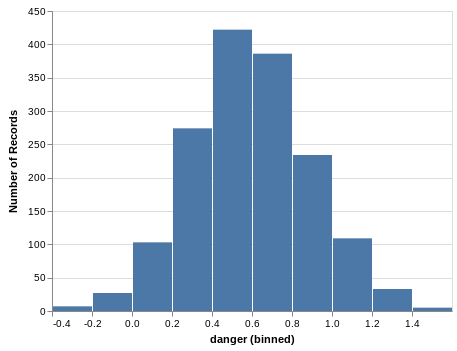

In [50]:
world = events.add_chaos_to_world(world)

alt.Chart(world.df_features).mark_bar().encode(
    alt.X("danger", bin=True),
    y='count()',
)

# Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [51]:
world.df_features.head(10)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation,z,danger
key,,,,,,,,,,,
0:0,0,1.0,0,0:0,2.0,desert,NaN,1.0,Lionfort,Lionfort,0.953
1:0,0,4.0,1,1:0,3.0,plain,NaN,1.0,Lionfort,Lionfort,0.705
2:0,0,6.0,2,2:0,5.0,plain,NaN,1.0,Lionfort,Lionfort,0.613
3:0,0,8.0,3,3:0,6.0,plain,NaN,1.0,Lionfort,Lionfort,0.366
4:0,0,10.0,4,4:0,9.0,plain,NaN,1.0,Lionfort,Lionfort,-0.197
5:0,0,14.0,5,5:0,8.0,plain,NaN,1.0,Lionfort,Lionfort,0.328
6:0,0,17.0,6,6:0,7.0,plain,NaN,1.0,Lionfort,Lionfort,0.402
7:0,0,20.0,7,7:0,7.0,plain,NaN,1.0,Lionfort,Lionfort,0.697
8:0,0,21.0,8,8:0,7.0,plain,NaN,1.0,Lionfort,Lionfort,1.101


In [52]:
with open('world.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)